## Objective: 

The goal of this model is to predict the item outlet sales of grocery super market called BIGMART, With over 22,000 products and over a 1200 brands which is located mainly in INDIA. The Model trained and tested using XGBoost Regression Algorithm which is a regression type Model.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn import metrics

## Read and Load the Data

In [2]:
mart_data = pd.read_csv('./Train.csv')

mart_data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


Categorical Features:

* Item_Identifier
* Item_Fat_Content
* Item_Type
* Outlet_Identifier
* Outlet_Size
* Outlet_Location_Type
* Outlet_Type

## Data Analysis

In [3]:
mart_data.shape

(8523, 12)

In [4]:
mart_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [5]:
# missing values are present in the dataset
mart_data.isnull().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

### Handling Missing Values

The missing values can be handled by replacing with 

1. numerical values with mean
2. categorical values with mode

In [6]:
# Item weight is a numerical value, so replace with mean

mart_data['Item_Weight'].fillna(mart_data['Item_Weight'].mean(),inplace=True)

In [7]:
# outlet size is a categorical feature, so replace it with mode by comparing outlet size with outlet type
# x represents outlet size
mode_outlet_size = mart_data.pivot_table(values='Outlet_Size',columns='Outlet_Type',aggfunc = ( lambda x:x.mode()[0]))

In [8]:
# when outlet type is grocerry store, at most time the outlet size is small ans so on
mode_outlet_size

Outlet_Type,Grocery Store,Supermarket Type1,Supermarket Type2,Supermarket Type3
Outlet_Size,Small,Small,Medium,Medium


In [9]:
missing_values = mart_data['Outlet_Size'].isnull()

In [10]:
missing_values

0       False
1       False
2       False
3        True
4       False
        ...  
8518    False
8519     True
8520    False
8521    False
8522    False
Name: Outlet_Size, Length: 8523, dtype: bool

In [11]:
mart_data.loc[missing_values,'Outlet_Size'] = mart_data.loc[missing_values,'Outlet_Type'].apply(lambda x:mode_outlet_size[x])

In [12]:
mart_data.isnull().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

## Data Analysis

In [13]:
mart_data.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.226124,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,9.310000,0.026989,93.826500,1987.000000,834.247400
50%,12.857645,0.053931,143.012800,1999.000000,1794.331000
75%,16.000000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


### visualizing Numerical Features

E:\Python\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


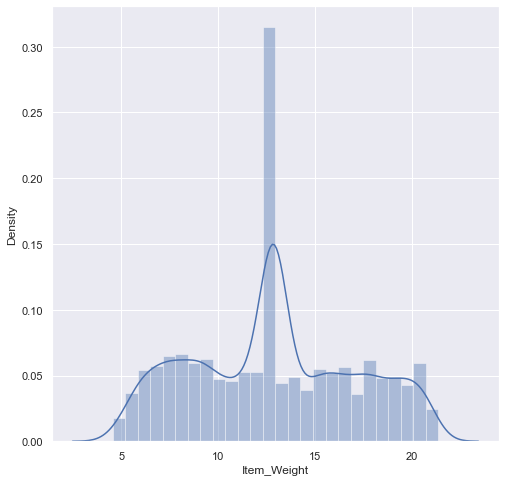

In [14]:
sns.set()

#distribution for Item weight
plt.figure(figsize=(8,8))
sns.distplot(mart_data['Item_Weight'])
plt.show()

E:\Python\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


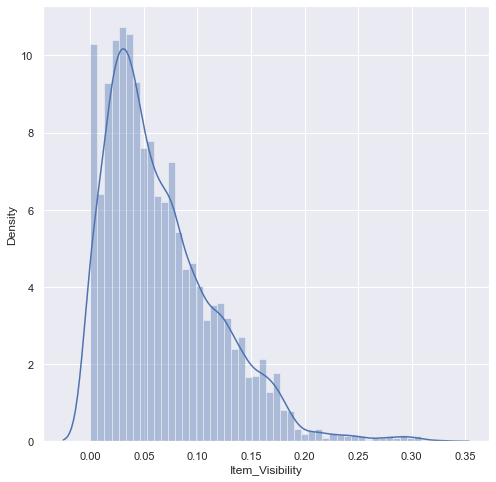

In [15]:
# Item Visibility distribution
plt.figure(figsize=(8,8))
sns.distplot(mart_data['Item_Visibility'])
plt.show()

E:\Python\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


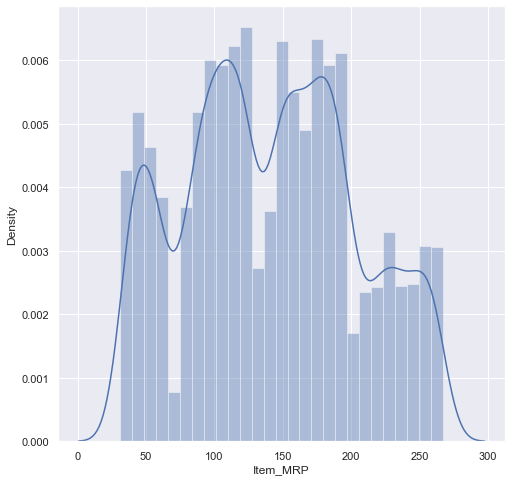

In [16]:
# Item MRP distribution
plt.figure(figsize=(8,8))
sns.distplot(mart_data['Item_MRP'])
plt.show()

E:\Python\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


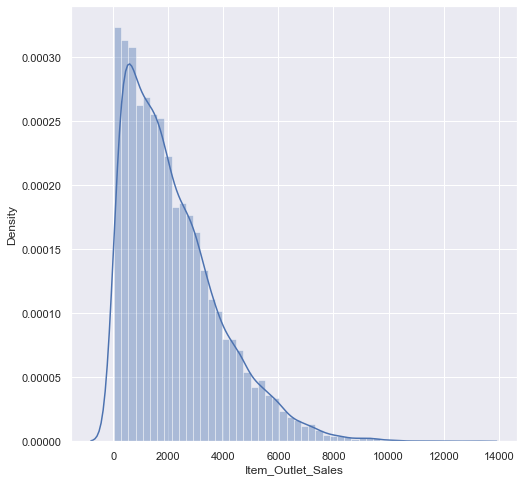

In [17]:
# Item_Outlet_Sales distribution
plt.figure(figsize=(8,8))
sns.distplot(mart_data['Item_Outlet_Sales'])
plt.show()

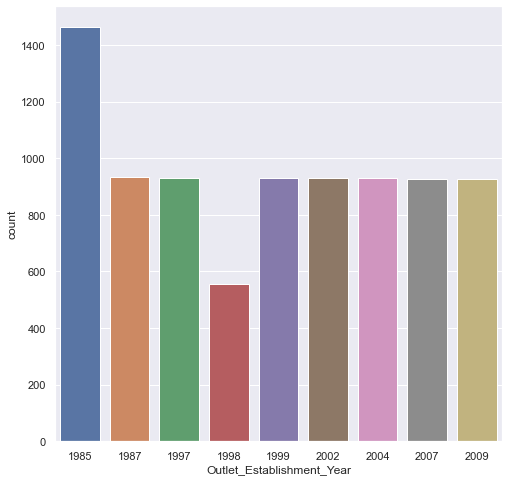

In [18]:
# Outlet_Establishment_Year column
plt.figure(figsize=(8,8))
sns.countplot(x='Outlet_Establishment_Year', data=mart_data)
plt.show()

### visualizing Categorical Features

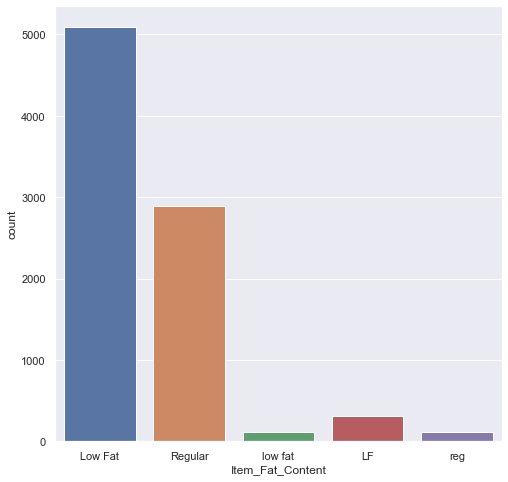

In [19]:
# Item_Fat_Content column
plt.figure(figsize=(8,8))
sns.countplot(x='Item_Fat_Content', data=mart_data)
plt.show()

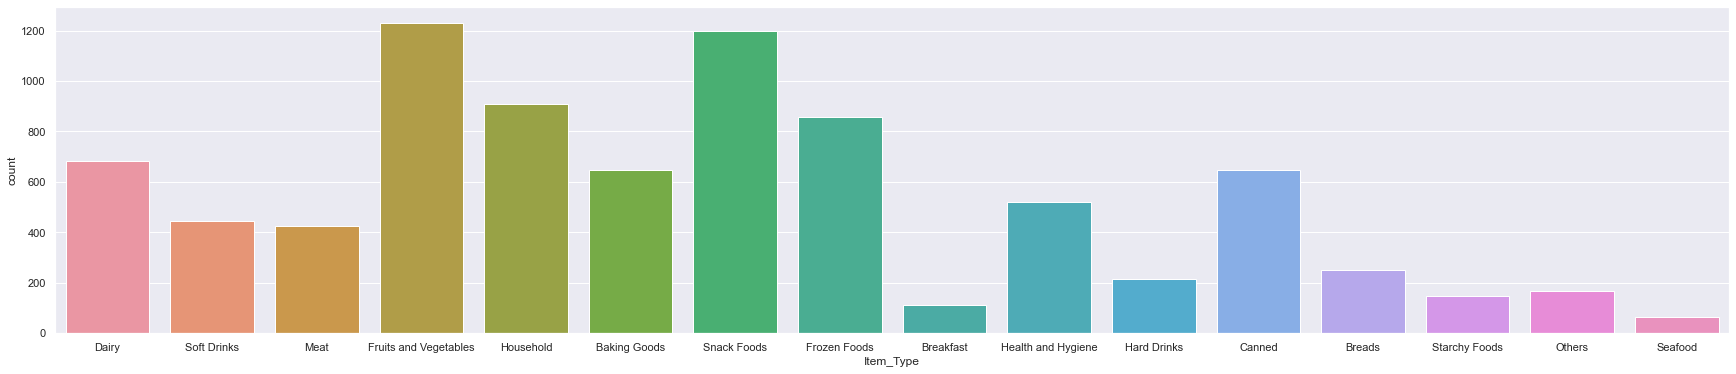

In [20]:
# Item_Type column
plt.figure(figsize=(30,6))
sns.countplot(x='Item_Type', data=mart_data)
plt.show()

## Data Preprocessing 

In [21]:
mart_data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,Small,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [22]:
mart_data['Item_Fat_Content'].unique()

array(['Low Fat', 'Regular', 'low fat', 'LF', 'reg'], dtype=object)

In [23]:
mart_data['Item_Fat_Content'].value_counts()

Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64

In [24]:
mart_data.replace({'Item_Fat_Content': {'low fat':'Low Fat','LF':'Low Fat', 'reg':'Regular'}}, inplace=True)

In [25]:
mart_data['Item_Fat_Content'].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

In [26]:
mart_data['Item_Fat_Content'].dtype

dtype('O')

In [27]:
mart_data['Item_Type'].value_counts()

Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: Item_Type, dtype: int64

In [28]:
mart_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                8523 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                8523 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


## Label Encoding

In [29]:
encoder = LabelEncoder()

In [30]:
#applying label encoding for all categorical features

mart_data['Item_Identifier'] = encoder.fit_transform(mart_data['Item_Identifier'])

mart_data['Item_Fat_Content'] = encoder.fit_transform(mart_data['Item_Fat_Content'])

mart_data['Item_Type'] = encoder.fit_transform(mart_data['Item_Type'])

mart_data['Outlet_Identifier'] = encoder.fit_transform(mart_data['Outlet_Identifier'])

mart_data['Outlet_Size'] = encoder.fit_transform(mart_data['Outlet_Size'])

mart_data['Outlet_Location_Type'] = encoder.fit_transform(mart_data['Outlet_Location_Type'])

mart_data['Outlet_Type'] = encoder.fit_transform(mart_data['Outlet_Type'])


In [31]:
mart_data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,156,9.30,0,0.016047,4,249.8092,9,1999,1,0,1,3735.1380
1,8,5.92,1,0.019278,14,48.2692,3,2009,1,2,2,443.4228
2,662,17.50,0,0.016760,10,141.6180,9,1999,1,0,1,2097.2700
3,1121,19.20,1,0.000000,6,182.0950,0,1998,2,2,0,732.3800
4,1297,8.93,0,0.000000,9,53.8614,1,1987,0,2,1,994.7052


## Splitting the features

In [32]:
X= mart_data.drop(columns='Item_Outlet_Sales',axis=1)
y = mart_data['Item_Outlet_Sales']

In [33]:
X.shape , y.shape

((8523, 11), (8523,))

## Splitting the dataset for Training and Testing

In [34]:
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.2, random_state=2)

## Model Training

In [35]:
xgb_model = XGBRegressor()

In [36]:
xgb_model.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

## Model Evaluation

In [38]:
# Predicting on training data

train_prediction = xgb_model.predict(X_train)

In [41]:
# R squared Value
r2_train_score = metrics.r2_score(y_train, train_prediction)

In [42]:
r2_train_score

0.8639680373364909

In [43]:
# Prediction on Test data

test_prediction = xgb_model.predict(X_test)

In [44]:
# R squared Value
r2_test_score = metrics.r2_score(y_test, test_prediction)

In [45]:
r2_test_score

0.5233136709735687